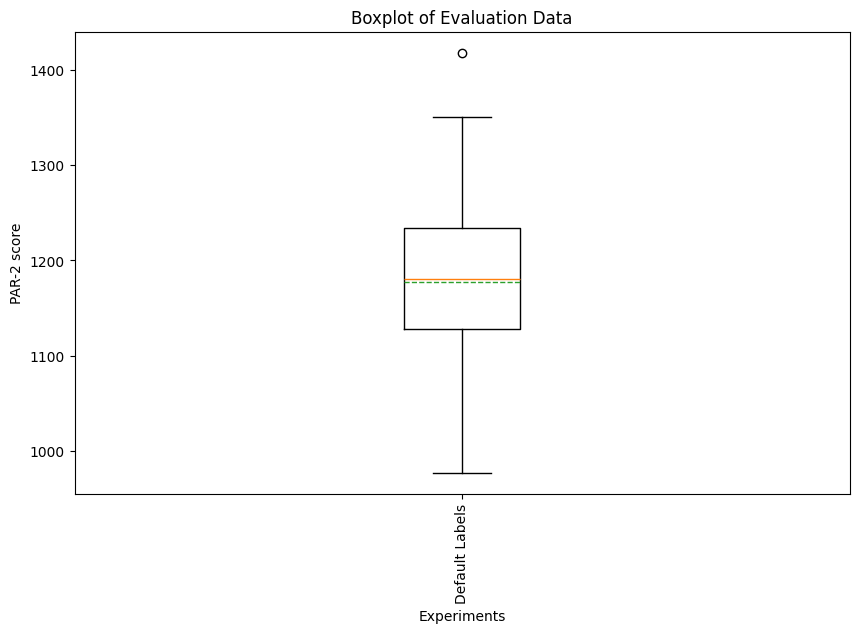

[1177.8587398450313]

In [6]:
from helpers import *
import pickle
from gbd_core.api import GBD

features = get_available_features()

df = pd.read_csv('top40.csv')

configs = df['configuration'].drop_duplicates().tolist()


def classify(seed):
    data = get_prediction_dataset(features, "family")

    family_counts = data['family'].value_counts()
    families_to_replace = family_counts[family_counts < 5].index
    data['family'] = data['family'].apply(lambda x: 'rest' if x in families_to_replace else x)
    data_train, data_test = train_test_split(data, test_size=0.2, random_state=seed, stratify=data["family"])

    data_train['config'] = ""
    for family in data_train['family'].unique():
        
        data_train.loc[data_train['family'] == family, 'config'] = getBest(data_train[data_train['family'] == family]['hash'].tolist())
    
    model = RandomForestClassifier()
    model.fit(data_train[features], data_train['config'])

    insts = data_test['hash'].tolist()
    y_pred = model.predict(data_test[features])

    predictions_df = pd.DataFrame(list(zip(data_test["hash"], y_pred)), columns=["hash", "predicted_index"])

    default_sum = getDefault(insts)
    virtual_sum = getVirtual(insts, configs)
    eval_sum = evalConfigPredict(predictions_df)

    return {
            'Default': default_sum,
            'Virtual': virtual_sum,
            'Eval': eval_sum
        }

results = []
for i in range(50):
    results.append(classify(i))

compareModels([results], ["Default Labels"])



In [7]:
with open('deflabels/deflabels.pkl', 'wb') as f:
    pickle.dump(results, f)

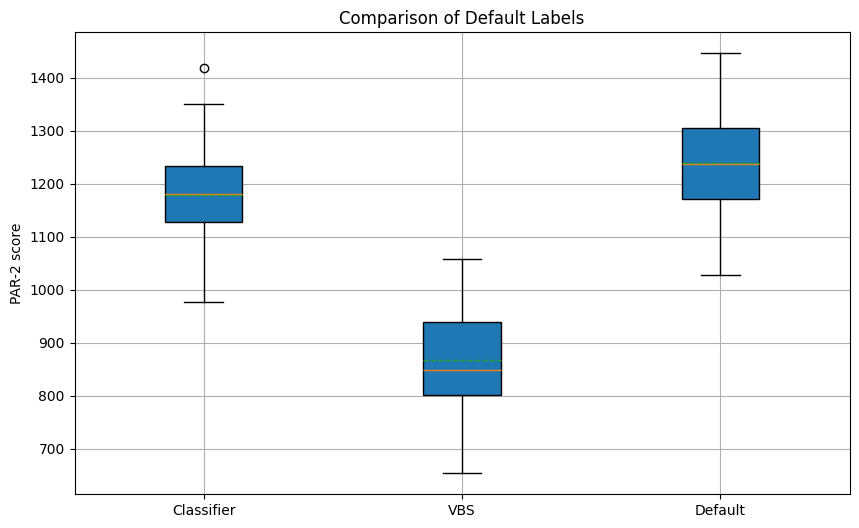

In [1]:
import pickle
from helpers import *

with open('deflabels/deflabels.pkl', 'rb') as f:
    results = pickle.load(f)

virtualDefaultEval(results, "Default Labels")